# **11762 Content-Based Image Retrieval**
## Master's Degree in Intelligent Systems
### University of the Balearic Islands
---

##### Write in the following the names of the members of the group:
- **Member 1:** Aina Maria Tur Serrano
- **Member 2:** Frank William Hammond Espinosa

# **Instructions**

**Do not delete any of the provided cells or functions**. Write your code in the indicated sections. You may add new cells or functions as needed to complete your work.  

Along with this assignment, please submit a comprehensive **report** in PDF format explaining your implemented solutions. The report should include, for example:

- **Technical Explanation**: Clearly describe the algorithms and techniques used, including relevant code snippets.
- **Results**: Present your results in a clear and concise manner. Use visualizations such as graphs or tables to enhance understanding.
- **Analysis**: Interpret your results and discuss their significance. Consider, for instance, the following questions:
  - Are the results as expected? Why or why not?
  - What factors might have influenced the results?
- **Conclusions**: Summarize your findings and provide overall conclusions about your project.
- ---

In [2]:
# Execute this cell to make sure 
# that external modules are reloaded
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [3]:
# Fill the following variable with
# the path to the Holidays (or Mini) dataset
dataset_dir = 'holidays_mini'

In [4]:
# Setup code for this assignment
import cv2
import math
import numpy as np
import os
import skimage.feature as skfeat
import zipfile
from holidays_dataset_handler import HolidaysDatasetHandler
from typing import Callable
import json

import assignment1 as a1

# Configuring Matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

# **Introduction**
In this assignment, you will first learn the tools that will be used throughout the labs. Then, you will implement and evaluate various image description methods to develop a simple Content-Based Image Retrieval (CBIR) system.

### Tools
Several tools and libraries will be used throughout the semester, including:

*   [Python 3](https://docs.python.org/3/tutorial/)
*   [NumPy](https://docs.scipy.org/doc/numpy/user/quickstart.html)
*   [OpenCV](https://docs.opencv.org/master/d6/d00/tutorial_py_root.html)

It is important to familiarize yourself with these tools. If you are not already familiar with them, please follow the links above and explore the tutorials. Quickstart guides are also available on the course website on [Aula Digital](https://ad.uib.es/).

### The INRIA Holidays Dataset
During this course, we will primarily use the INRIA Holidays dataset. This dataset consists of a collection of personal holiday photos from the authors, along with additional images purposefully taken to evaluate robustness to image transformations such as rotations, viewpoint changes, illumination variations, blurring, and more. The dataset includes a wide variety of scene types (natural landscapes, man-made structures, water, fire effects, etc.), with all images available in high resolution.

The dataset is organized into **500 groups**, each representing a distinct scene or object. For evaluation, the first image in each group serves as a **query image**, and the other images in the group are considered **relevant images** for that query. For example:

- *100900.jpg* is the query image.
- *100901.jpg* and *100902.jpg* are relevant images from the same group.

The dataset comprises a total of **1491 images**, including:

- **500 queries** (one for each group).
- **991 relevant images**.

### The INRIA Holidays Dataset (MINI)
To facilitate development, a reduced version of the INRIA Holidays dataset, called the *mini* dataset, is provided. **You should mainly use this version for this assignment.** It contains **50 images**, including:

- **19 queries**.
- **31 relevant images**.

> **Note**: Both datasets can be downloaded from [Aula Digital](https://ad.uib.es/). After downloading, unzip the files into a writable directory on your machine. Ensure that the corresponding variable at the beginning of this notebook is updated with the correct path to the dataset.

The datasets follow this structure:
```
holidays/
  ├── holidays_images.dat
  ├── images/
  │     ├── 100000.jpg
  │     ├── 100001.jpg
  │     └── ...
  └── features/
        ├── 100000.siftgeo
        ├── 100001.siftgeo
        └── ...
  ...
```
where:

- **`holidays_images.dat`**: This file lists the filenames of all images in the dataset.
- **`images/`**: Contains the high-resolution image files.
- **`features/`**: Includes the `.siftgeo` files, which store a set of extracted features (keypoints and descriptors) using SIFT for each image. Ensure these files are present if feature-based operations are required.

The `holidays_images.dat` file can also serve as ground truth for performance evaluation of retrieval systems, as explained in a later section.

### Using the *HolidaysDatasetHandler* Class
The `HolidaysDatasetHandler` class is designed to help you manage and interact with the INRIA Holidays dataset efficiently. It provides functionality for loading images, extracting keypoints and descriptors, and calculating evaluation metrics like Average Precision (AP) and Mean Average Precision (mAP).

**Key Features**
- Load and retrieve query/database images.
- Access ground truth data for evaluation.
- Load precomputed keypoints and descriptors for feature-based tasks.
- Compute AP and mAP for query evaluation.

#### Example Usage
**Importing and Initializing**
```python
# Initialize the dataset handler
dataset = HolidaysDatasetHandler(dataset_dir, load_features=True)
```

**Loading and Displaying an Image**
```python
# Get an image from the dataset
image_name = "100900.jpg"
image = dataset.get_image(image_name)

# Display the image
plt.imshow(image)
plt.axis('off')  # Optional, to hide axes
plt.show()
```

**Accesing Query and Database Images**
```python
# List all query images
query_images = dataset.get_query_images()
print(f"Number of query images: {len(query_images)}")

# List all database images
database_images = dataset.get_database_images()
print(f"Number of database images: {len(database_images)}")
```

**Loading Keypoints and Descriptors**
```python
# Load keypoints and descriptors for a specific image
kps = dataset.get_kps("100900.jpg")
descs = dataset.get_descriptors("100900.jpg")

# Print the first keypoint and its descriptor
print(f"Keypoint: {kps[0].pt}, Descriptor shape: {descs.shape}")
```

**Computing Average Precision (AP)**
```python
# Compute AP for a single query with a ranked list of images
query_name = "100900.jpg"
ranked_list = ["100901.jpg", "100902.jpg"]
ap = dataset.compute_AP(query_name, ranked_list)
print(f"Average Precision (AP) for {query_name}: {ap}")
```

**Computing Mean Average Precision (mAP)**
```python
# Compute mAP for multiple queries
ranked_dict = {
    "100900.jpg": ["100901.jpg", "100902.jpg"],
    "101000.jpg": ["101001.jpg"]
}
map_score = dataset.compute_mAP(ranked_dict)
print(f"Mean Average Precision (mAP): {map_score}")
```

## **Global Descriptors**

Once our development environment is set up, we can begin working on the assignment. In this section, we will explore and evaluate various global descriptors to build a simple image retrieval system.

### General Framework

To streamline our workflow, we will begin by developing essential utility functions and classes. Start by implementing a [Python class]((https://docs.python.org/3/tutorial/classes.html)) named `CBIR` in `assignment1.py`, which will encapsulate the core functionalities of a CBIR system. The class should adhere to the provided method descriptions. Assume the existence of a function, `desc_func`, that computes a global descriptor for a given image. This design enables the use of the same class with different descriptor methods, as we will explore later in the assignment.

### Color Histograms
- Let's begin with histograms. In the `assignment1.py` file, implement the function `compute_1d_color_hist` to compute a descriptor based on a 1D color histogram. The final image descriptor will be the concatenation of the **normalized** color histograms from the three individual channels (B, G, and R).

- Next, implement the function called `compute_2d_color_hist` to compute a global descriptor for the image using 2D color histograms. The image descriptor will be the concatenation of the **normalized** histograms derived from the three possible combinations of color channels (B/G, B/R, and G/R).

> **Useful functions**: [cv2.calcHist](https://docs.opencv.org/4.2.0/d6/dc7/group__imgproc__hist.html), [np.histogram](https://docs.scipy.org/doc/numpy/reference/generated/numpy.histogram.html)

Check your implementations using the following cell:

In [62]:
# Initialize the dataset handler
dataset = HolidaysDatasetHandler(dataset_dir, load_features=False) # We don't need features now

# Get an image from the dataset
image_name = "100900.jpg"
image = dataset.get_image(image_name)

# Bins: 32
h = a1.compute_1d_color_hist(image, 32);
assert h.shape == (96, )

# Bins: 16
h = a1.compute_1d_color_hist(image, 16);
assert h.shape == (48, )

# Bins: 8
h = a1.compute_1d_color_hist(image, 8);
assert h.shape == (24, )

# Bins: 32
h = a1.compute_2d_color_hist(image, 32);
assert h.shape == (3072, )

# Bins: 16
h = a1.compute_2d_color_hist(image, 16);
assert h.shape == (768, )

**Task 1:**

Using the `HolidaysDatasetHandler` and `CBIR` classes, your task in the following cell is to compute the **mean Average Precision (mAP)** of this image retrieval system on this dataset. The image descriptors should be calculated using **1D histograms** with **8 bins**.

In [71]:
# Fill this variable with the resulting mAP
mAP_hist_1d = 0.0

dataset = a1.DatasetHandler(dataset_dir, load_features=False)
retriever = a1.GlobalCBIR(a1.compute_1d_color_hist, bins_per_hist=8)
retriever.build_image_db(dataset.load_database_images())
mAP_hist_1d = retriever.compute_mAP(dataset)

print('Mean Average Precision (mAP): %.5f' % mAP_hist_1d)

Mean Average Precision (mAP): 0.70903


**Task 2:**

Study the effect of changing the number of bins per histogram.

*Write in the following the code required to answer the question. You may add more code or markdown cells as needed.*

Note that there are $2^8$ possible values for the intensity of a given pixel ($0, 1, \dots, 255$). Call a binning **homogenous** if each bin has the same number of assigned values (for instance, $0-31, 32-64, \dots, 224-255$). This implies that if $v$ is the number of different values per bin in a homogenous binning of pixel intensities, and $n$ is the number of bins, then $n\cdot v=2^8$. This means that $n=2^k$ for some $k\in\{0,\dots,8\}$.

Therefore, a good criterion to choose the optimal number of bins is to look only for homogenous binnings, and thus vary $k$ and find the highest mAP among all possibilities.

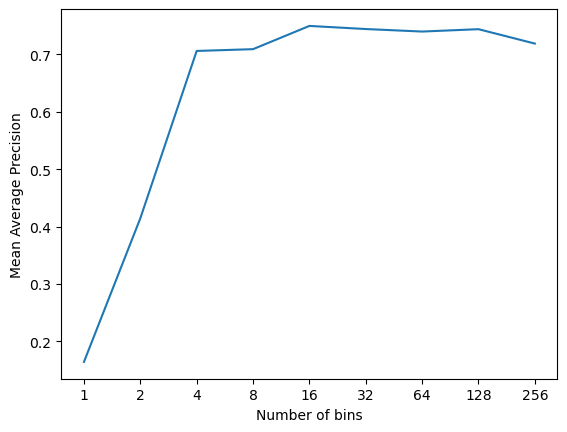

The optimal number of bins is 16, with a mAP of 0.7495141038871688


In [7]:
mAP_values = [0.0] * 9
for k in range(9):
    retriever = a1.GlobalCBIR(
        a1.compute_1d_color_hist,
        bins_per_hist = 2**k
    )
    
    mAP_values[k]=retriever.compute_mAP(dataset)
    
plt.plot(mAP_values)
plt.xlabel("Number of bins")
plt.ylabel("Mean Average Precision")
plt.xticks(list(range(9)), labels = [2**k for k in range(9)])
plt.show()

optimal_k = np.argmax(mAP_values)
print(f"The optimal number of bins is {2**optimal_k}, with a mAP of {mAP_values[optimal_k]}")

**Task 3:**

Again, using the `HolidaysDatasetHandler` and `CBIR` classes, your task in the following cell is to compute the **mean Average Precision (mAP)** of this image retrieval system on this dataset. However, this time the image descriptors should be calculated using **2D histograms** with **8 bins**.

In [ ]:
# Fill this variable with the resulting mAP
mAP_hist_2d = 0.0

# YOUR CODE HERE
cbir = a1.GlobalCBIR(a1.compute_2d_color_hist, bins_per_hist=8)
cbir.build_image_db(dataset.load_database_images())
mAP_hist_2d = cbir.compute_mAP(dataset)
# -----

print('Mean Average Precision (mAP): %.5f' % mAP_hist_2d)

######BUILDING IMAGE DATABASE######
######FINISHED RANKING IMAGES######
Mean Average Precision (mAP): 0.80455


**Task 4:**

As for the 1D case, study the effect of changing the number of bins per histogram.

*Write in the following the code required to answer the question. You may add more code or markdown cells as needed.*

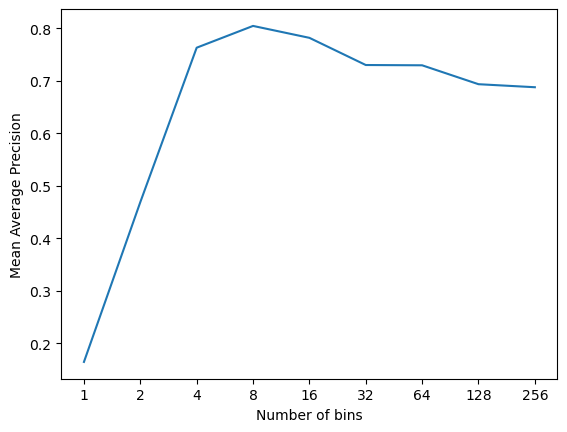

The optimal number of bins is 8, with a mAP of 0.8045549479760006


In [9]:
mAP_values = [0.0] * 9
for k in range(9):
    retriever = a1.GlobalCBIR(
        a1.compute_2d_color_hist,
        bins_per_hist = 2**k,
    )
    
    mAP_values[k]=retriever.compute_mAP(dataset)
    
plt.plot(mAP_values)
plt.xlabel("Number of bins")
plt.ylabel("Mean Average Precision")
plt.xticks(list(range(9)), labels = [2**k for k in range(9)])
plt.show()

optimal_k = np.argmax(mAP_values)
print(f"The optimal number of bins is {2**optimal_k}, with a mAP of {mAP_values[optimal_k]}")

**Task 5:**

What other options can be implemented to improve the quality of retrieval using histograms? Experiment with some of them.

*Write in the following the code required to answer the question. You may add more code or markdown cells as needed.*

We can attempt to normalize the histograms differently, perhaps with the Manhattan norm instead of the euclidean:

In [30]:
def compute_1d_norm(img, bins_per_hist = 32, type='RGB', norm='L1'):
    """
    Compute a 1d color histogram of the image.
  
    - img: Color image (Numpy array)
    - bins_per_hist: Number of bins per histogram

    RETURN: 
    - A numpy array of shape (bins_per_hist * 3,)
    """
    
    histograms = np.zeros((3, bins_per_hist))
    img = change_colorspace(img, type)
    for i in range(3):
        h, _ = np.histogram(img[:,:,i], bins = bins_per_hist, range = (0,255))
        if norm == 'L1':
            histograms[i, :] = h / np.sum(h) 
        elif norm == 'MAX':
            histograms[i, :] = h / np.max(h) 
        elif norm == 'L2': 
            histograms[i, :] = h/np.linalg.norm(h)
    return histograms.flatten()

def change_colorspace(img, type='RGB',):
    if type == 'HSV':
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    elif type == 'LAB':
        img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    return img

In [32]:
type = ['RGB', 'HSV', 'LAB']
norm = ['L1', 'L2', 'MAX']
for t in type: 
    for n in norm: 
        mAP_hist_1d = 0.0 
        cbir = a1.GlobalCBIR(compute_1d_norm, bins_per_hist=8,type=t, norm=n)
        cbir.build_image_db(dataset.load_database_images())
        mAP_hist_1d  = cbir.compute_mAP(dataset)
        print(f'Mean Average Precision (mAP) with images {t} and norm {n} : {mAP_hist_1d}')

Mean Average Precision (mAP) with images RGB and norm L1 : 0.7053255073959408
Mean Average Precision (mAP) with images RGB and norm L2 : 0.7090325341017861
Mean Average Precision (mAP) with images RGB and norm MAX : 0.7387634266891233
Mean Average Precision (mAP) with images RGB and norm MAN : 0.7053255073959408
Mean Average Precision (mAP) with images HSV and norm L1 : 0.8503936122357173
Mean Average Precision (mAP) with images HSV and norm L2 : 0.8459292169818484
Mean Average Precision (mAP) with images HSV and norm MAX : 0.7902223507486665
Mean Average Precision (mAP) with images HSV and norm MAN : 0.8503936122357173
Mean Average Precision (mAP) with images LAB and norm L1 : 0.8177527151211361
Mean Average Precision (mAP) with images LAB and norm L2 : 0.79546783625731
Mean Average Precision (mAP) with images LAB and norm MAX : 0.8245614035087719
Mean Average Precision (mAP) with images LAB and norm MAN : 0.8177527151211361


The optimal number of bins is 128, for type RGB and normalization L1, with a mAP of 0.7594114073061442
The optimal number of bins is 16, for type RGB and normalization L2, with a mAP of 0.7495141038871688
The optimal number of bins is 8, for type RGB and normalization MAX, with a mAP of 0.7387634266891233
The optimal number of bins is 128, for type RGB and normalization MAN, with a mAP of 0.7594114073061442
The optimal number of bins is 32, for type HSV and normalization L1, with a mAP of 0.8555555555555554
The optimal number of bins is 32, for type HSV and normalization L2, with a mAP of 0.8525081643502695
The optimal number of bins is 8, for type HSV and normalization MAX, with a mAP of 0.7902223507486665
The optimal number of bins is 32, for type HSV and normalization MAN, with a mAP of 0.8555555555555554
The optimal number of bins is 8, for type LAB and normalization L1, with a mAP of 0.8177527151211361
The optimal number of bins is 16, for type LAB and normalization L2, with a mAP

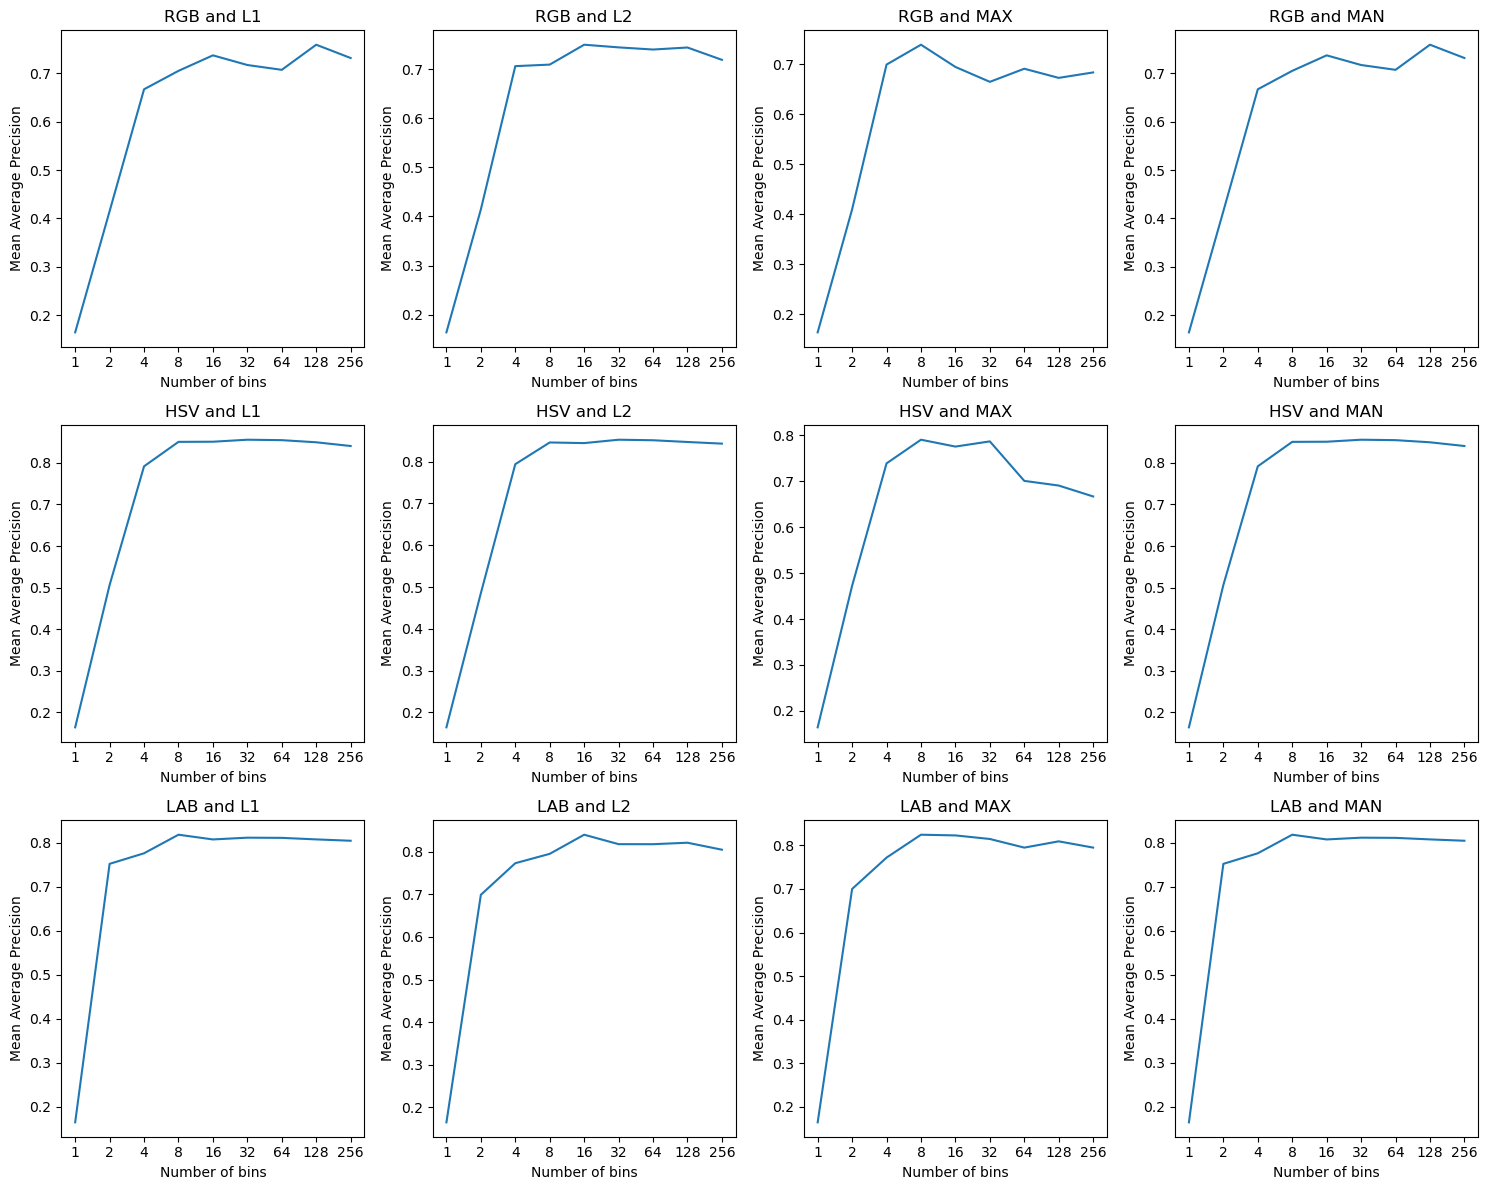

In [78]:
fig, axes = plt.subplots(3, 4, figsize=(15, 12))
type = ['RGB', 'HSV', 'LAB']
norm = ['L1', 'L2', 'MAX','MAN']
for i,t in enumerate(type): 
    for j,n in enumerate(norm): 
        mAP_values = [0.0] * 9
        for k in range(9):
            retriever = a1.GlobalCBIR(
                compute_1d_norm,
                bins_per_hist = 2**k,
                type = t,
                norm=n
            )
            mAP_values[k] = retriever.compute_mAP(dataset)
        axes[i,j].plot(mAP_values)
        axes[i,j].set_xlabel("Number of bins")
        axes[i,j].set_ylabel("Mean Average Precision")
        axes[i,j].set_title(f"{t} and {n}")
        axes[i,j].set_xticks(list(range(9)), labels = [2**k for k in range(9)])
        optimal_k = np.argmax(mAP_values)
        print(f"The optimal number of bins is {2**optimal_k}, for type {t} and normalization {n}, with a mAP of {mAP_values[optimal_k]}")
plt.tight_layout()
plt.show()

2D case

In [75]:
def compute_2d_norm(img, bins_per_hist = 16, type='RGB', norm='L1'):
    """
    Compute a 2d color histogram of the image.
    
    The final descriptor will be the concatenation of 3 normalized 2D histograms: B/G, B/R and G/R.
  
    - img: Color image (Numpy array)
    - bins_per_hist: Number of bins per histogram

    RETURN:
    - A numpy array of shape (bins_per_hist * bins_per_hist * 3,)
    """
    img = change_colorspace(img, type)
    c1, c2, c3 = cv2.split(img)
    histograms = np.zeros((3, bins_per_hist * bins_per_hist))

    h = cv2.calcHist([c1, c2],[0,1],None, [bins_per_hist, bins_per_hist], ranges = [0,255,0,255]) # B/G
    histograms[0,:] =  normalization(norm,h)

    h = cv2.calcHist([c2, c3],[0,1],None, [bins_per_hist, bins_per_hist], ranges = [0,255,0,255]) # B/R
    histograms[1,:] =  normalization(norm,h)

    h = cv2.calcHist([c1, c3],[0,1],None, [bins_per_hist, bins_per_hist], ranges = [0,255,0,255]) # G/R
    histograms[2,:] = normalization(norm,h)

    return histograms.flatten()

def normalization(norm, h):
    total = 0
    if norm == 'L1':
        total = h.flatten()/np.linalg.norm(h,1)
    elif norm == 'L2':
        total = h.flatten()/np.linalg.norm(h)
    elif norm == 'MAX':
        total = h.flatten()/ np.max(h)
    elif norm == 'SUM':
        total= h.flatten()/ np.sum(h)
    return total

In [76]:
type = ['RGB', 'HSV', 'LAB']
norm = ['L1', 'L2', 'MAX','SUM']
for t in type: 
    for n in norm: 
        mAP_hist_2d = 0.0 
        cbir = a1.GlobalCBIR(compute_2d_norm, bins_per_hist=8,type=t, norm=n)
        cbir.build_image_db(dataset.load_database_images())
        mAP_hist_2d  = cbir.compute_mAP(dataset)
        print(f'Mean Average Precision (mAP) with images {t} and norm {n} : {mAP_hist_2d}')

Mean Average Precision (mAP) with images RGB and norm L1 : 0.7369647895963686
Mean Average Precision (mAP) with images RGB and norm L2 : 0.8045549479760006
Mean Average Precision (mAP) with images RGB and norm MAX : 0.7170739348370926
Mean Average Precision (mAP) with images RGB and norm MAN : 0.7285505430242272
Mean Average Precision (mAP) with images HSV and norm L1 : 0.8083959899749373
Mean Average Precision (mAP) with images HSV and norm L2 : 0.8437761069340016
Mean Average Precision (mAP) with images HSV and norm MAX : 0.8221874129768866
Mean Average Precision (mAP) with images HSV and norm MAN : 0.8796783625730994
Mean Average Precision (mAP) with images LAB and norm L1 : 0.8578947368421053
Mean Average Precision (mAP) with images LAB and norm L2 : 0.8396825396825397
Mean Average Precision (mAP) with images LAB and norm MAX : 0.7964912280701755
Mean Average Precision (mAP) with images LAB and norm MAN : 0.8180451127819548


The optimal number of bins is 4, for type RGB and normalization L1, with a mAP of 0.74728098156076
The optimal number of bins is 8, for type RGB and normalization L2, with a mAP of 0.8045549479760006
The optimal number of bins is 8, for type RGB and normalization MAX, with a mAP of 0.7170739348370926
The optimal number of bins is 4, for type RGB and normalization MAN, with a mAP of 0.7405179615705931
The optimal number of bins is 16, for type HSV and normalization L1, with a mAP of 0.8159860353224196
The optimal number of bins is 16, for type HSV and normalization L2, with a mAP of 0.8758771929824561
The optimal number of bins is 8, for type HSV and normalization MAX, with a mAP of 0.8221874129768866
The optimal number of bins is 16, for type HSV and normalization MAN, with a mAP of 0.8803675856307436
The optimal number of bins is 8, for type LAB and normalization L1, with a mAP of 0.8578947368421053
The optimal number of bins is 128, for type LAB and normalization L2, with a mAP of 0.

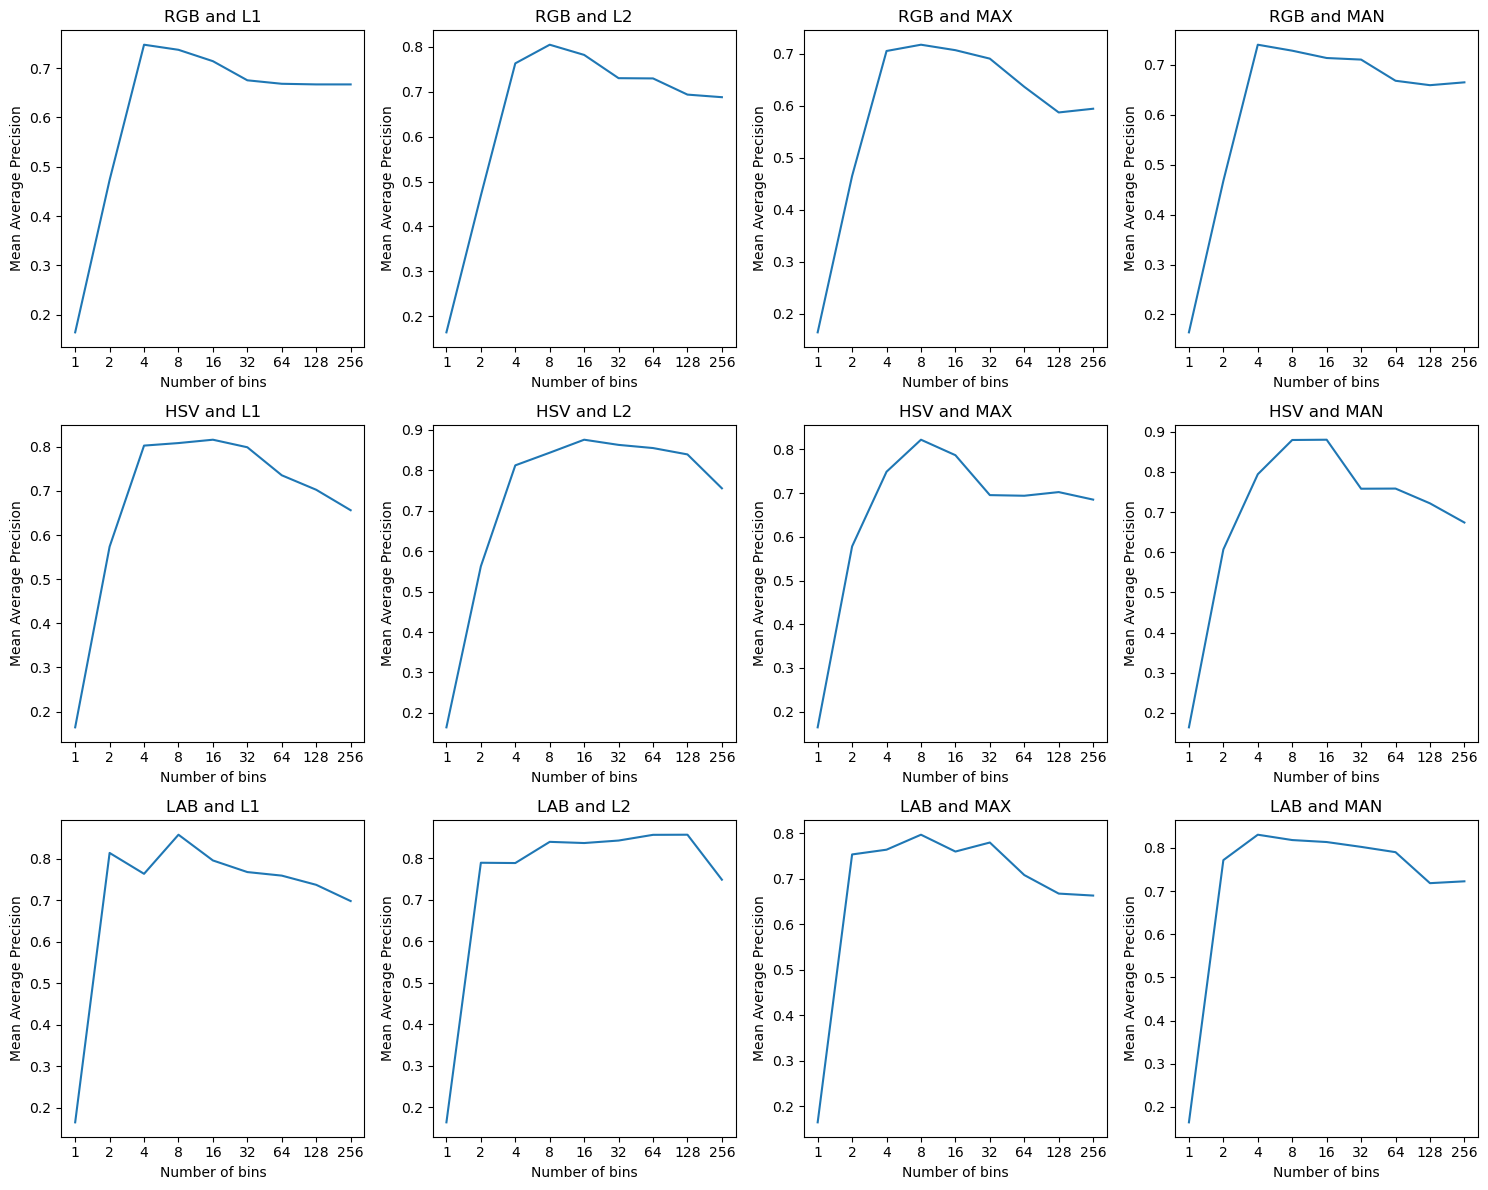

In [77]:
fig, axes = plt.subplots(3, 4, figsize=(15, 12))
type = ['RGB', 'HSV', 'LAB']
norm = ['L1', 'L2', 'MAX','MAN']
for i,t in enumerate(type): 
    for j,n in enumerate(norm): 
        mAP_values = [0.0] * 9
        for k in range(9):
            retriever = a1.GlobalCBIR(
                compute_2d_norm,
                bins_per_hist = 2**k,
                type = t,
                norm=n
            )
            mAP_values[k] = retriever.compute_mAP(dataset)
        axes[i,j].plot(mAP_values)
        axes[i,j].set_xlabel("Number of bins")
        axes[i,j].set_ylabel("Mean Average Precision")
        axes[i,j].set_title(f"{t} and {n}")
        axes[i,j].set_xticks(list(range(9)), labels = [2**k for k in range(9)])
        optimal_k = np.argmax(mAP_values)
        print(f"The optimal number of bins is {2**optimal_k}, for type {t} and normalization {n}, with a mAP of {mAP_values[optimal_k]}")
plt.tight_layout()
plt.show()

### Local Binary Patterns (LBP)

Let's try LBP. Implement the function called `compute_lbp_descriptor` to calculate an image descriptor based on LBP. The descriptor should use the *rotation-invariant and uniform (RIU)* version of the algorithm. The final image descriptor will be the normalized histogram of the resulting LBP image.

> **Useful functions**: [skimage.feature.local_binary_pattern](https://scikit-image.org/docs/dev/api/skimage.feature.html?highlight=lbp#skimage.feature.local_binary_pattern)

Check your implementation using the following cell:

In [63]:
h = a1.compute_lbp_descriptor(image, 8, 1);
assert h.shape == (10, )

**Task 6:**

As previously, your task in the following cell is to compute the **mean Average Precision (mAP)** of this image retrieval system on this dataset using the `HolidaysDatasetHandler` and `CBIR` classes. However, this time, the descriptors should be calculated using the `compute_lbp_descriptor` function using **8 neighbors for each pixel at a distance of 1 pixel**.

In [ ]:
# Fill this variable with the resulting mAP
mAP_lbp = 0.0

cbir = a1.GlobalCBIR(a1.compute_lbp_descriptor, p=8, r=1)
cbir.build_image_db(dataset.load_database_images())
mAP_lbp = cbir.compute_mAP(dataset)

print('Mean Average Precision (mAP): %.5f' % mAP_lbp)

######BUILDING IMAGE DATABASE######
######FINISHED RANKING IMAGES######
Mean Average Precision (mAP): 0.62210


**Task 7:**

Study the effect of changing the number of neighboring pixels $p$ and the radius $r$.

*Write in the following the code required to answer the question. You may add more code or markdown cells as needed.*

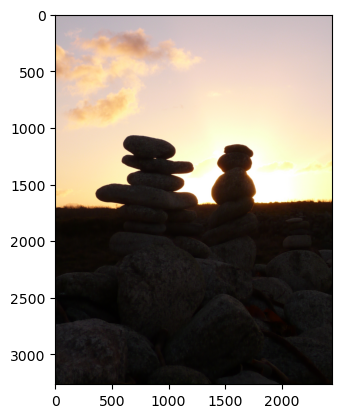

In [65]:
plt.imshow(image)
plt.show()

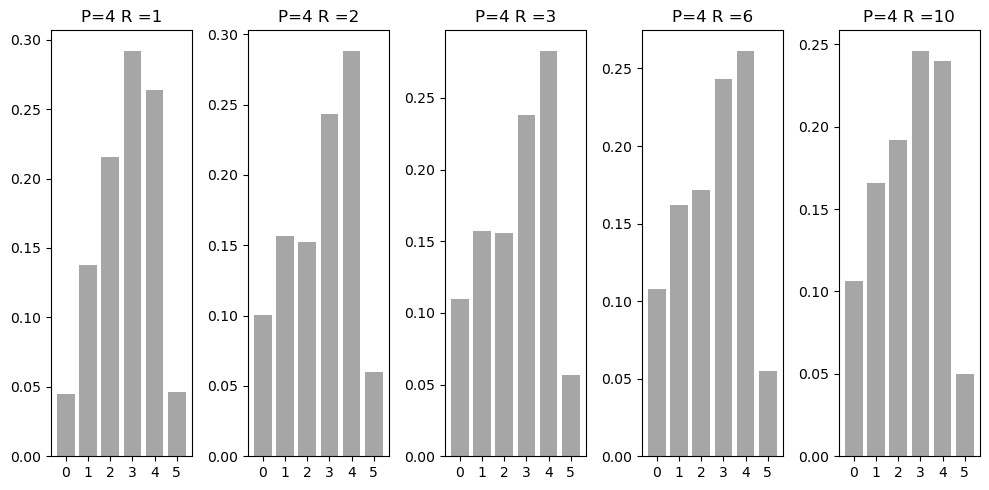

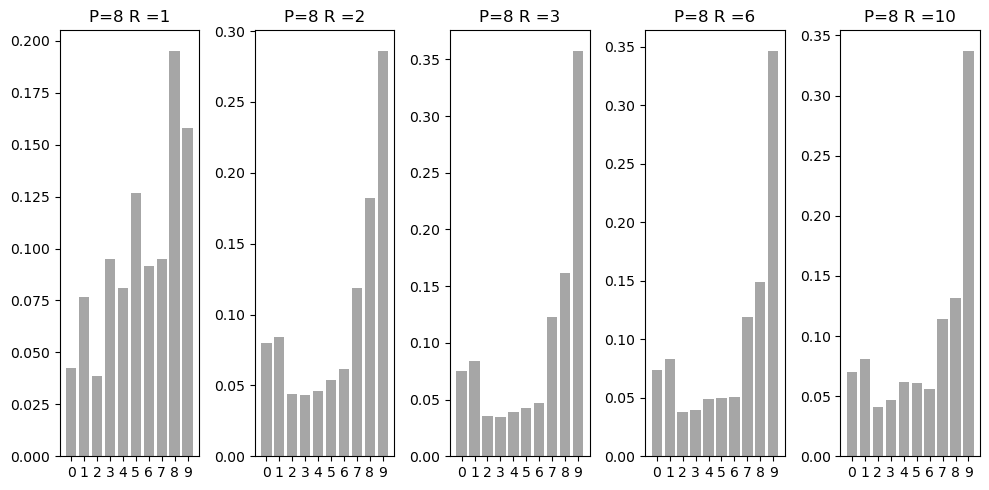

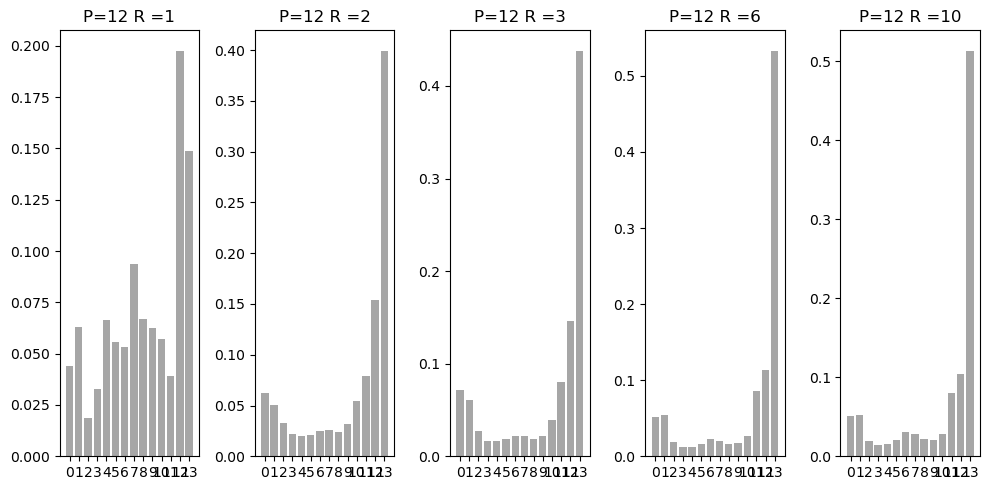

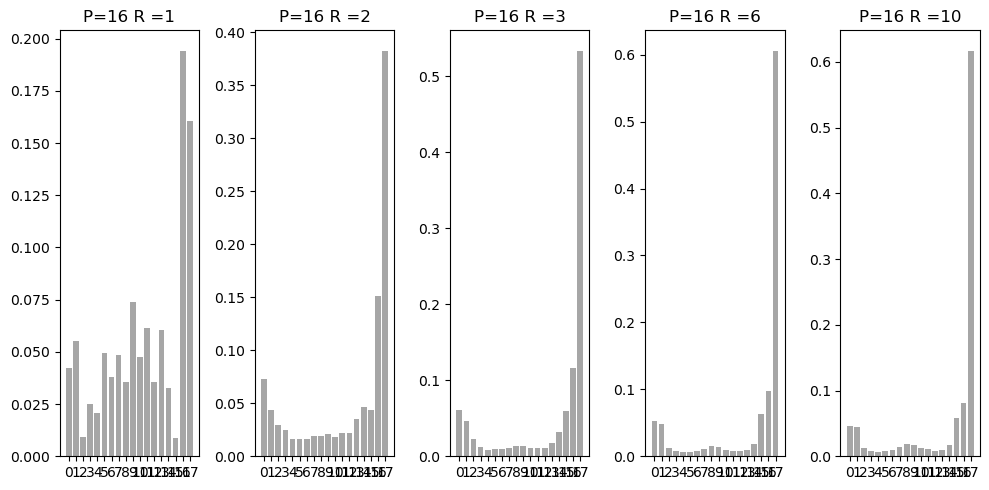

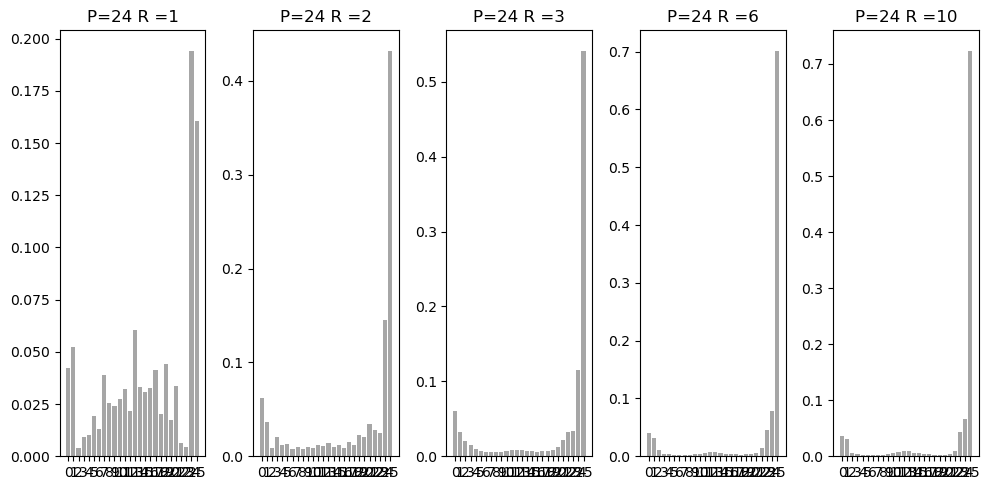

In [66]:
p_neighbors =[4,8,12,16,24]
radiuses =[1,2,3,6,10]
for x,p in enumerate(p_neighbors):
    fig, axes = plt.subplots(1, 5, figsize=(10, 5))
    for y,r in enumerate(radiuses): 
        h = a1.compute_lbp_descriptor(image, p, r)
        ax_hist = axes[y]
        ax_hist.bar(range(len(h)), h, color='gray', alpha=0.7)
        ax_hist.set_title(f'P={p} R ={r}')
        ax_hist.set_xticks(np.arange(p + 2))
    plt.tight_layout()
    plt.show()

In [37]:
p_neighbors =[4,8,12,16,24]
radiuses =[1,2,3,6,10]
mAP_lbp = 0.0
fig, axes = plt.subplots(5, 5, figsize=(16, 8))
for p in p_neighbors:
    for r in radiuses: 
        cbir = a1.GlobalCBIR(a1.compute_lbp_descriptor, p=p, r=r)
        cbir.build_image_db(dataset.load_database_images())
        mAP_lbp = cbir.compute_mAP(dataset)
        print('Mean Average Precision (mAP) for p= %i and r = %i : %.5f' % (p,r,mAP_lbp))

Mean Average Precision (mAP) for p= 4 and r = 1 : 0.62115
Mean Average Precision (mAP) for p= 4 and r = 2 : 0.70421
Mean Average Precision (mAP) for p= 4 and r = 3 : 0.62016
Mean Average Precision (mAP) for p= 4 and r = 6 : 0.54284
Mean Average Precision (mAP) for p= 4 and r = 10 : 0.55282
Mean Average Precision (mAP) for p= 8 and r = 1 : 0.62407
Mean Average Precision (mAP) for p= 8 and r = 2 : 0.61143
Mean Average Precision (mAP) for p= 8 and r = 3 : 0.59619
Mean Average Precision (mAP) for p= 8 and r = 6 : 0.65505
Mean Average Precision (mAP) for p= 8 and r = 10 : 0.52165
Mean Average Precision (mAP) for p= 12 and r = 1 : 0.64445
Mean Average Precision (mAP) for p= 12 and r = 2 : 0.57653
Mean Average Precision (mAP) for p= 12 and r = 3 : 0.58055
Mean Average Precision (mAP) for p= 12 and r = 6 : 0.58901
Mean Average Precision (mAP) for p= 12 and r = 10 : 0.56273
Mean Average Precision (mAP) for p= 16 and r = 1 : 0.68045
Mean Average Precision (mAP) for p= 16 and r = 2 : 0.57857
Mean

**Task 8:**

Implement a grid over the image, computing the LBP histogram for each cell. Then, concatenate these histograms to form a global descriptor for the image. Investigate the impact of this improvement on the retrieval performance.

*Write in the following the code required to answer the question. You may add more code or markdown cells as needed.*

In [20]:
def grid_image(image, num_tiles):
    H = image.shape[0]
    W = image.shape[1]
    split = int(math.sqrt(num_tiles))

    split_height = H // split
    split_width = W // (num_tiles // split)

    tiles = []
    for i in range(split):
        for j in range(num_tiles // split):
            tile = image[i * split_height: (i + 1) * split_height, j * split_width: (j + 1) * split_width]
            tiles.append(tile)

    return tiles


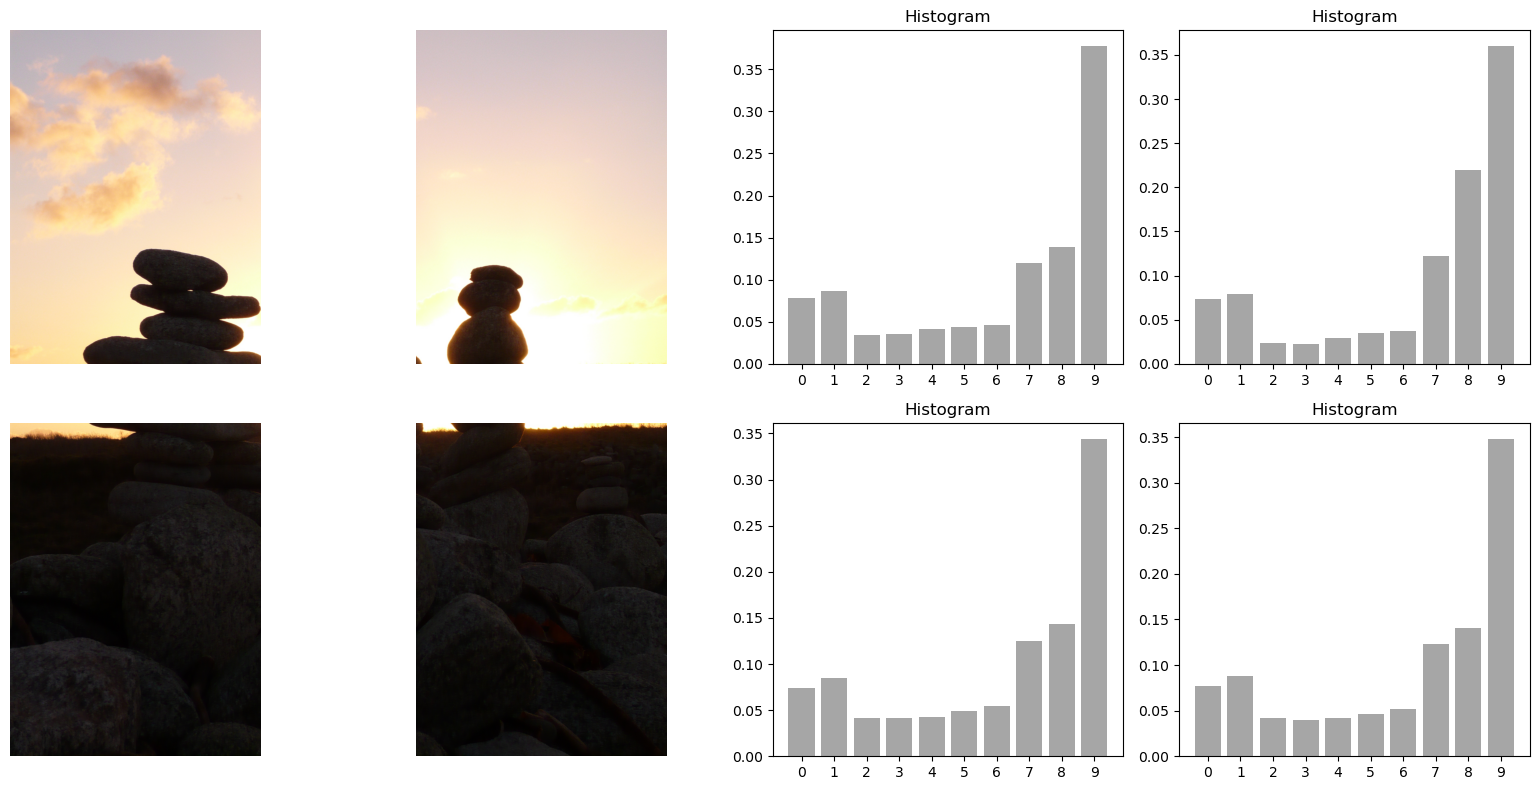

In [28]:
tiles = grid_image(image, 4)
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i,tile in enumerate(tiles):
    h = a1.compute_lbp_descriptor(tile, 8, 3)
    row, col = divmod(i, 2)
    axes[row, col].imshow(tile)
    axes[row, col].axis("off")
    ax_hist = axes[row, col + 2]
    ax_hist.bar(range(len(h)), h, color='gray', alpha=0.7)
    ax_hist.set_title('Histogram')
    ax_hist.set_xticks(np.arange(8 + 2))
plt.tight_layout()
plt.show()

In [22]:
def compute_lbp_for_tiles(image,num_tiles,p,r):
    histograms = []
    tiles = grid_image(image,num_tiles)
    histograms = [a1.compute_lbp_descriptor(tile,p,r) for tile in tiles]
    return np.concatenate(histograms)

In [27]:
p_neighbors =[4,8,12,16,24]
radiuses =[1,2,3,6,10]
mAP_lbp = 0.0
for p in p_neighbors:
    for r in radiuses: 
        cbir = a1.GlobalCBIR(compute_lbp_for_tiles,num_tiles=4, p=p, r=r)
        cbir.build_image_db(dataset.load_database_images())
        mAP_lbp = cbir.compute_mAP(dataset)
        print('Mean Average Precision (mAP) for p= %i and r = %i : %.5f' % (p,r,mAP_lbp))
        

Mean Average Precision (mAP) for p= 4 and r = 1 : 0.68592
Mean Average Precision (mAP) for p= 4 and r = 2 : 0.71790
Mean Average Precision (mAP) for p= 4 and r = 3 : 0.70931
Mean Average Precision (mAP) for p= 4 and r = 6 : 0.64821
Mean Average Precision (mAP) for p= 4 and r = 10 : 0.63815
Mean Average Precision (mAP) for p= 8 and r = 1 : 0.68478
Mean Average Precision (mAP) for p= 8 and r = 2 : 0.69889
Mean Average Precision (mAP) for p= 8 and r = 3 : 0.62763
Mean Average Precision (mAP) for p= 8 and r = 6 : 0.62561
Mean Average Precision (mAP) for p= 8 and r = 10 : 0.64030
Mean Average Precision (mAP) for p= 12 and r = 1 : 0.70738
Mean Average Precision (mAP) for p= 12 and r = 2 : 0.64605
Mean Average Precision (mAP) for p= 12 and r = 3 : 0.56071
Mean Average Precision (mAP) for p= 12 and r = 6 : 0.56604
Mean Average Precision (mAP) for p= 12 and r = 10 : 0.56101
Mean Average Precision (mAP) for p= 16 and r = 1 : 0.70523
Mean Average Precision (mAP) for p= 16 and r = 2 : 0.64494
Mean

## **Local Descriptors**

In this section, we will focus on retrieving images by leveraging local descriptors discussed during the class. These descriptors will help us analyze and compare images based on their distinct visual features.

### Extracting Interest Points

Let's start by writing the function `extract_interest_points` in `assignment1.py` to extract a set of keypoints from an image along with their corresponding descriptors. The function will take a parameter called `feat_type` to specify the method used for keypoint detection and description. This parameter can have one of the following string values:

- **`SIFT`**: SIFT detector and descriptor.
- **`FAST_BRIEF`**: FAST detector with BRIEF descriptor.
- **`ORB`**: ORB detector and descriptor.


> **Useful functions**: [cv2.SIFT_create()](https://docs.opencv.org/4.5.4/d7/d60/classcv_1_1SIFT.html#ad337517bfdc068ae0ba0924ff1661131), [cv2.FastFeatureDetector_create](https://docs.opencv.org/4.5.4/df/d74/classcv_1_1FastFeatureDetector.html#ab986f2ff8f8778aab1707e2642bc7f8e), [cv2.xfeatures2d.BriefDescriptorExtractor_create](https://docs.opencv.org/4.5.4/d1/d93/classcv_1_1xfeatures2d_1_1BriefDescriptorExtractor.html#ae3bc52666010fb137ab6f0d32de51f60), [cv2.ORB_create](https://docs.opencv.org/4.5.4/db/d95/classcv_1_1ORB.html#aeff0cbe668659b7ca14bb85ff1c4073b)

By combining these tools, you can implement the function to handle different types of keypoint detection and description techniques effectively.

Check your implementation using the following cell:

1590 keypoints detected.
Descriptors shape: (1590, 128)


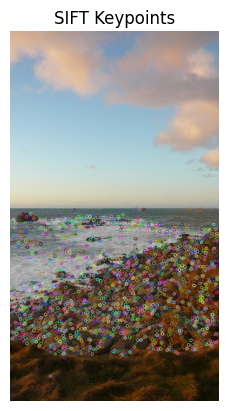

In [ ]:
# Initialize the dataset handler
dataset = HolidaysDatasetHandler(dataset_dir, load_features=False) # We don't need features now

# Get an image from the dataset
image_name = "100800.jpg"
image = dataset.get_image(image_name)

# Check if the image was loaded correctly
if image is None:
    print(f"Error: Could not load the image {image_name}.")
else:
    # Extract interest points and descriptors
    img_resized = cv2.resize(image, None, fx=0.25, fy=0.25, interpolation = cv2.INTER_CUBIC)
    kps, des = a1.extract_interest_points(img_resized, 'SIFT', nfeats=2000, thresh=75)
    
    # Check if any keypoints were detected
    if len(kps) == 0:
        print("No keypoints were detected in the image.")
    else:
        print(f"{len(kps)} keypoints detected.")
        # Display the shape of the descriptors
        print(f"Descriptors shape: {des.shape}")
        
        # Draw the keypoints on the image
        sift_image = cv2.drawKeypoints(img_resized, kps, None)
        
        # Display the image without axes
        plt.imshow(sift_image)  # Convert BGR to RGB for Matplotlib
        plt.axis('off')  # Remove axes
        plt.title('SIFT Keypoints')
        plt.show()

### Matching Images

- Next, implement the function called `find_matches` to match two sets of descriptors. Since descriptor types vary, we will use:
    - **Brute-force matching** for binary descriptors (e.g., BRIEF, ORB).  
    - **FLANN-based matching** for floating-point descriptors (e.g., SIFT).
            
-  Implement the function called `filter_matches` to refine the matching results using the **Nearest Neighbor Distance Ratio (NNDR) criterion**. This method helps remove ambiguous matches by ensuring that the best match is significantly better than the second-best match. This helps to discard ambiguous matches and improves robustness by reducing false positives.

> **Useful links**: [cv2.BFMatcher_create](https://docs.opencv.org/4.5.4/d3/da1/classcv_1_1BFMatcher.html#ac6418c6f87e0e12a88979ea57980c020), [cv2.FlannBasedMatcher](https://docs.opencv.org/4.5.4/dc/de2/classcv_1_1FlannBasedMatcher.html#a7b17083dda906384465a32952c1bbe3b), [Feature Matching](https://docs.opencv.org/4.5.4/dc/dc3/tutorial_py_matcher.html)

### Filtering Matches

Implement the function called `filter_matches` to refine the matching results using the **Nearest Neighbor Distance Ratio (NNDR) criterion**. This method helps remove ambiguous matches by ensuring that the best match is significantly better than the second-best match.

Check your implementation of these functions using the following cell:

Raw matches found: 152234
Filtered matches: 1481


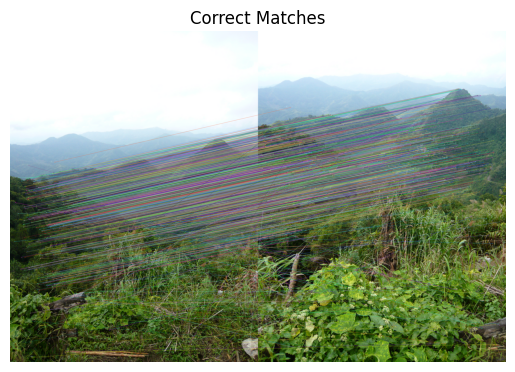

In [7]:
# Initialize the dataset handler
dataset = HolidaysDatasetHandler(dataset_dir, load_features=False)  # We don't need features now

# Get images from the dataset
image1_name = "100000.jpg"
image2_name = "100001.jpg"

image1 = dataset.get_image(image1_name)
image2 = dataset.get_image(image2_name)

# Check if images were loaded correctly
if image1 is None or image2 is None:
    print("Error: One or both images could not be loaded.")
else:
    # Extract keypoints and descriptors for both images
    kps_q, des_q = a1.extract_interest_points(image1, 'FAST_BRIEF', thresh=12)
    kps_t, des_t = a1.extract_interest_points(image2, 'FAST_BRIEF', thresh=12)

    # Check if descriptors were extracted properly
    if des_q is None or des_t is None or len(des_q) == 0 or len(des_t) == 0:
        print("Error: No descriptors found in one or both images.")
    else:
        # Find and filter matches
        raw_matches = a1.find_matches(des_q, des_t)
        print(f"Raw matches found: {len(raw_matches)}")

        matches = a1.filter_matches(raw_matches, ratio=0.6)
        print(f"Filtered matches: {len(matches)}")
        
        # Draw matches
        img_matches = cv2.drawMatches(
            image1, kps_q, image2, kps_t, matches, None, 
            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
        )

        # Display the result
        plt.imshow(img_matches)
        plt.axis('off')  # Remove axes for a cleaner display
        plt.title('Correct Matches')
        plt.show()


## Evaluating Performance

Using the `HolidaysDatasetHandler` and the functions you have implemented, your task is to complete the `evaluate` function in `assignment1.py` to compute the **mean Average Precision (mAP)** for an image retrieval system based on **local image features**. This time, images will be compared using **local feature descriptors**. Given a query image, the closest match in the database will be the **image with the highest number of matches after filtering**. You should apply a **threshold** to determine the minimum number of matches required for an image to be considered a **correct match**.

**Task 9:**

In the following cell, your task is to compute the **mean Average Precision (mAP)** for the image retrieval system using the `evaluate()` function. The goal is to evaluate the retrieval system's performance for each method (SIFT, FAST/BRIEF, and ORB) and fine-tune their respective parameters to achieve the best possible mAP.

For each method:
1. **SIFT**: Adjust parameters such as the number of features (`nfeats`) and the threshold (`thresh`).
2. **FAST/BRIEF**: Experiment with the number of keypoints, thresholds, and descriptors.
3. **ORB**: Modify the number of features (`nfeats`) and other relevant settings.

Your objective is to achieve the highest mAP score by optimizing these parameters for each method.


We will perform a grid search on the different parameter combinations in order to find the best mAPs, but in order to avoid repeating executions on further exercises (in which we have to measure time and number of features computed), we will register those values straight away. To do this, we used the custom methods `LocalCBIR.compute_mAP`, `compute_feature_lengths` and `evaluate_and_benchmark_in_all_combinations`. We simply store the results - which include the mAP, total number of features computed, execution time, and the parameters used - into the `results` dictionary, and then save that dictionary into a JSON file.

Technically, we didn't use the `evaluate` function for this, but we nevertheless implemented it (see `assignment1.py`), and under the hood it uses the same code (`LocalCBIR.compute_mAP`) that we use here. The reason for not using the method is that, in order to get the total number of features computed by the system, we needed access to the `LocalCBIR` instance, so we would have had to change the signature of `evaluate` by either returning the instance or the number of features, but changing signatures was not allowed.

In [17]:
dataset = a1.DatasetHandler(dataset_dir, load_features=False)

def sift_callable(nfeats, thresh, ratio):
    retriever = a1.LocalCBIR('SIFT', nfeats=nfeats, thresh=thresh, ratio=ratio)
    mAP = retriever.compute_mAP(dataset)
    total_features = sum(retriever.compute_feature_lengths().values())

    return mAP, total_features

def fastbrief_callable(nfeats, thresh, ratio):
    retriever = a1.LocalCBIR('SIFT', nfeats=nfeats, thresh=thresh, ratio=ratio)
    mAP = retriever.compute_mAP(dataset)
    total_features = sum(retriever.compute_feature_lengths().values())

    return mAP, total_features

def orb_callable(nfeats, thresh, ratio):
    retriever = a1.LocalCBIR('ORB', nfeats=nfeats, thresh=thresh, ratio=ratio)
    mAP = retriever.compute_mAP(dataset)
    total_features = sum(retriever.compute_feature_lengths().values())

    return mAP, total_features

callables={
    "SIFT":sift_callable,
    "ORB":orb_callable,
    "FAST_BRIEF":fastbrief_callable,
}

parameter_lists = {
    'SIFT':{'nfeats': [100, 500, 1000, 2000, 4000], 'thresh':[0], 'ratio':[0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9]},
    'FAST_BRIEF':{'nfeats': [0], 'thresh':[32, 64, 75], 'ratio':[0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9]},
    'ORB':{'nfeats': [1000, 2000, 4000, 8000, 10000], 'thresh':[16, 32, 64, 75], 'ratio':[0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9]}
}

results={}
methods = ["SIFT", "FAST_BRIEF", "ORB"]
for method in methods:
    print("========"+method+"========")
    results[method] = a1.evaluate_and_benchmark_in_all_combinations(callables[method], parameter_lists[method])
    print("========"+"="*len(method)+"========")


========SIFT========
Trying parameter combination:	{'nfeats': 100, 'thresh': 0, 'ratio': 0.4}
Trying parameter combination:	{'nfeats': 100, 'thresh': 0, 'ratio': 0.5}
Trying parameter combination:	{'nfeats': 100, 'thresh': 0, 'ratio': 0.6}
Trying parameter combination:	{'nfeats': 100, 'thresh': 0, 'ratio': 0.7}
Trying parameter combination:	{'nfeats': 100, 'thresh': 0, 'ratio': 0.75}
Trying parameter combination:	{'nfeats': 100, 'thresh': 0, 'ratio': 0.8}
Trying parameter combination:	{'nfeats': 100, 'thresh': 0, 'ratio': 0.9}
Trying parameter combination:	{'nfeats': 500, 'thresh': 0, 'ratio': 0.4}
Trying parameter combination:	{'nfeats': 500, 'thresh': 0, 'ratio': 0.5}
Trying parameter combination:	{'nfeats': 500, 'thresh': 0, 'ratio': 0.6}
Trying parameter combination:	{'nfeats': 500, 'thresh': 0, 'ratio': 0.7}
Trying parameter combination:	{'nfeats': 500, 'thresh': 0, 'ratio': 0.75}
Trying parameter combination:	{'nfeats': 500, 'thresh': 0, 'ratio': 0.8}
Trying parameter combination

Now we can write the results to disk in a JSON format. A final transformation we do to the `results` dictionary is converting it into a list of dictionaries, each of which stores the method it was computed with, and the results. This way, the results are more "DataFrame-like" and thus easier to manipulate.

In [18]:
expanded_results = []
for method, result in results.items():

    method_results = list(map(lambda d: {'method':method, **d}, result))
    expanded_results.extend(method_results)

In [9]:
with open('timed_results.json', 'w', encoding='utf-8') as f:
    json.dump(expanded_results, f, indent=4)

Finally, we can get the best mAP for each method by reading from this JSON:

In [13]:
# Fill these variables with the best resulting mAPs
best_mAP_SIFT = 0.0
best_mAP_FASTBRIEF = 0.0
best_mAP_ORB = 0.0

with open('timed_results.json', 'r', encoding='utf-8') as f:
    extended_results = json.load(f)

def get_best_params(method):
    return max(filter(lambda d: d['method']==method, expanded_results), key = lambda d: d['mAP'])

best_results_SIFT = get_best_params('SIFT')
best_results_FASTBRIEF = get_best_params('FAST_BRIEF')
best_results_ORB = get_best_params('ORB')

best_mAP_SIFT = best_results_SIFT['mAP']
best_mAP_FASTBRIEF = best_results_FASTBRIEF['mAP']
best_mAP_ORB = best_results_ORB['mAP']

# Print the best mAPs for each method
print('Best mAP (SIFT): %.5f' % best_mAP_SIFT)
print('Best mAP (FAST/BRIEF): %.5f' % best_mAP_FASTBRIEF)
print('Best mAP (ORB): %.5f' % best_mAP_ORB)

Best mAP (SIFT): 0.89239
Best mAP (FAST/BRIEF): 0.87814
Best mAP (ORB): 0.87775


Besides just knowing the best values for the mAP, it is interesting to know what the best parameter combinations were:

In [16]:
print(f"Best paramater combination (SIFT): nfeats = {best_results_SIFT['nfeats']}, ratio = {best_results_SIFT['ratio']}")
print(f"Best paramater combination (FAST/BRIEF): thresh = {best_results_FASTBRIEF['thresh']}, ratio = {best_results_FASTBRIEF['ratio']}")
print(f"Best paramater combination (ORB): nfeats = {best_results_ORB['nfeats']}, thresh = {best_results_ORB['thresh']}, ratio = {best_results_ORB['ratio']}")



Best paramater combination (SIFT): nfeats = 2000, ratio = 0.6
Best paramater combination (FAST/BRIEF): thresh = 32, ratio = 0.4
Best paramater combination (ORB): nfeats = 8000, thresh = 32, ratio = 0.75


Of course, we know from the last task that the highest mAP was achieved for SIFT. However, to answer this question in greater detail, it is interesting to see performance among the different parameter combinations used in Task 9, in order to also discuss robustness. We use a simple utility method for printing the results:

In [27]:
def print_results(method, keys):
    print(f"Visualizing results for {method}:")
    for result in filter(lambda d: d['method']==method, expanded_results):
        parameter_string=""
        for key in keys:
            parameter_string+=f"'{key}'={result[key]}, "

        print(f"For the parameter combination {parameter_string} mAP was {round(result['mAP'],3)}")


First, let's take a look at SIFT:



In [28]:
print_results('SIFT', ['nfeats', 'ratio'])

Visualizing results for SIFT:
For the parameter combination 'nfeats'=2000, 'ratio'=0.6,  mAP was 0.892
For the parameter combination 'nfeats'=4000, 'ratio'=0.5,  mAP was 0.838
For the parameter combination 'nfeats'=1000, 'ratio'=0.7,  mAP was 0.832
For the parameter combination 'nfeats'=4000, 'ratio'=0.4,  mAP was 0.83
For the parameter combination 'nfeats'=4000, 'ratio'=0.6,  mAP was 0.829
For the parameter combination 'nfeats'=2000, 'ratio'=0.5,  mAP was 0.818
For the parameter combination 'nfeats'=2000, 'ratio'=0.7,  mAP was 0.809
For the parameter combination 'nfeats'=1000, 'ratio'=0.5,  mAP was 0.8
For the parameter combination 'nfeats'=1000, 'ratio'=0.6,  mAP was 0.796
For the parameter combination 'nfeats'=2000, 'ratio'=0.4,  mAP was 0.784
For the parameter combination 'nfeats'=2000, 'ratio'=0.75,  mAP was 0.775
For the parameter combination 'nfeats'=2000, 'ratio'=0.8,  mAP was 0.758
For the parameter combination 'nfeats'=4000, 'ratio'=0.7,  mAP was 0.74
For the parameter combin

Seems like either using too few features (less than $1000$) or setting the ratio too high ($0.9$) yielded poor results, but other than that, the results were consistently good.

Second, let's see FAST+BRIEF:

In [29]:
print_results('FAST_BRIEF', ['thresh', 'ratio'])

Visualizing results for FAST_BRIEF:
For the parameter combination 'thresh'=32, 'ratio'=0.4,  mAP was 0.878
For the parameter combination 'thresh'=64, 'ratio'=0.4,  mAP was 0.864
For the parameter combination 'thresh'=64, 'ratio'=0.6,  mAP was 0.857
For the parameter combination 'thresh'=75, 'ratio'=0.5,  mAP was 0.847
For the parameter combination 'thresh'=32, 'ratio'=0.5,  mAP was 0.844
For the parameter combination 'thresh'=64, 'ratio'=0.5,  mAP was 0.841
For the parameter combination 'thresh'=75, 'ratio'=0.4,  mAP was 0.841
For the parameter combination 'thresh'=75, 'ratio'=0.6,  mAP was 0.811
For the parameter combination 'thresh'=32, 'ratio'=0.6,  mAP was 0.806
For the parameter combination 'thresh'=75, 'ratio'=0.7,  mAP was 0.769
For the parameter combination 'thresh'=32, 'ratio'=0.7,  mAP was 0.769
For the parameter combination 'thresh'=64, 'ratio'=0.7,  mAP was 0.764
For the parameter combination 'thresh'=32, 'ratio'=0.75,  mAP was 0.723
For the parameter combination 'thresh'=6

For this method, results had less variance overall. In general terms, small ratios worked best since they discriminate more, and this algorithm can generate many features which need to be filtered.

Finally, let's see the results for ORB:

In [30]:
print_results('ORB', ['nfeats', 'thresh', 'ratio'])

Visualizing results for ORB:
For the parameter combination 'nfeats'=8000, 'thresh'=32, 'ratio'=0.75,  mAP was 0.878
For the parameter combination 'nfeats'=8000, 'thresh'=16, 'ratio'=0.75,  mAP was 0.86
For the parameter combination 'nfeats'=8000, 'thresh'=32, 'ratio'=0.8,  mAP was 0.852
For the parameter combination 'nfeats'=4000, 'thresh'=32, 'ratio'=0.7,  mAP was 0.837
For the parameter combination 'nfeats'=10000, 'thresh'=32, 'ratio'=0.75,  mAP was 0.833
For the parameter combination 'nfeats'=8000, 'thresh'=16, 'ratio'=0.8,  mAP was 0.826
For the parameter combination 'nfeats'=8000, 'thresh'=32, 'ratio'=0.7,  mAP was 0.822
For the parameter combination 'nfeats'=10000, 'thresh'=32, 'ratio'=0.7,  mAP was 0.816
For the parameter combination 'nfeats'=10000, 'thresh'=16, 'ratio'=0.8,  mAP was 0.816
For the parameter combination 'nfeats'=4000, 'thresh'=32, 'ratio'=0.8,  mAP was 0.814
For the parameter combination 'nfeats'=4000, 'thresh'=16, 'ratio'=0.8,  mAP was 0.809
For the parameter co

For this method, there seemed to be a lot of variance, with some combinations reaching mAPs of as low as $0.27$. However, there seemed to be a "sweet spot" when using combinations of parameters with a low threshold, high number of features and a median ratio.

After examining the data, it is clear that SIFT yielded the best results, FAST+BRIEF's were the most consistent and ORB's were generally the worst and required some fine-tuning, but it worked well for specific parameter combinations.

**Task 11:**

Compare the three methods in terms of detection and description speed. Which one is the fastest? Which one is the slowest?

> **Hints**:
> - [Here](https://jakevdp.github.io/PythonDataScienceHandbook/01.07-timing-and-profiling.html) you can find a useful resource on timing in Jupyter Notebooks.
> - You can also consider using the `time` module.
> - To provide a measure independent of the number of features detected, you can compute, for example, features per millisecond (features/ms).

*Write in the following the code required to answer the question. You may add more code or markdown cells as needed.*

First, we can compute the features/ms metric suggested. We'll divide the total number of features computed among all images in the database by the total execution time:

In [42]:
for result in expanded_results:
    result['feats/ms'] = result['total_features']/result['execution_time_ms']

expanded_results.sort(key=lambda d: d['mAP'], reverse=True)

It will be useful to modify the printing method from last task for visualizing the results. We'll only show the top 15 results for each method since it makes little sense to discuss speed for very bad perfomances:

In [58]:
def print_timed_results(method, keys):
    print(f"Visualizing timed results for {method}:")
    for result in list(filter(lambda d: d['method']==method, expanded_results))[:15]:
        parameter_string=""
        for key in keys:
            parameter_string+=f"'{key}'={result[key]}, "

        print(f"For the parameter combination {parameter_string}the algorithm computed {round(result['feats/ms'], 3)} features/ms and mAP was {round(result['mAP'],3)}. Total execution time was {round(result['execution_time_ms']/1000,3)}s.")


First, we visualize the results for SIFT:

In [59]:
print_timed_results('SIFT', ['nfeats', 'ratio'])

Visualizing timed results for SIFT:
For the parameter combination 'nfeats'=2000, 'ratio'=0.6, the algorithm computed 1.352 features/ms and mAP was 0.892. Total execution time was 40.482s.
For the parameter combination 'nfeats'=4000, 'ratio'=0.5, the algorithm computed 2.034 features/ms and mAP was 0.838. Total execution time was 49.719s.
For the parameter combination 'nfeats'=1000, 'ratio'=0.7, the algorithm computed 0.789 features/ms and mAP was 0.832. Total execution time was 38.487s.
For the parameter combination 'nfeats'=4000, 'ratio'=0.4, the algorithm computed 2.08 features/ms and mAP was 0.83. Total execution time was 48.614s.
For the parameter combination 'nfeats'=4000, 'ratio'=0.6, the algorithm computed 2.095 features/ms and mAP was 0.829. Total execution time was 48.261s.
For the parameter combination 'nfeats'=2000, 'ratio'=0.5, the algorithm computed 1.331 features/ms and mAP was 0.818. Total execution time was 41.135s.
For the parameter combination 'nfeats'=2000, 'ratio'=0

Notice how the number of features computed per millisecond does not correlate too clearly to the mAP. Typical execution times fall just short of a minute.

Then, we print the results for FAST+BRIEF:

In [60]:
print_timed_results('FAST_BRIEF', ['thresh', 'ratio'])

Visualizing timed results for FAST_BRIEF:
For the parameter combination 'thresh'=32, 'ratio'=0.4, the algorithm computed 3.03 features/ms and mAP was 0.878. Total execution time was 345.261s.
For the parameter combination 'thresh'=64, 'ratio'=0.4, the algorithm computed 3.048 features/ms and mAP was 0.864. Total execution time was 343.242s.
For the parameter combination 'thresh'=64, 'ratio'=0.6, the algorithm computed 3.028 features/ms and mAP was 0.857. Total execution time was 345.453s.
For the parameter combination 'thresh'=75, 'ratio'=0.5, the algorithm computed 3.037 features/ms and mAP was 0.847. Total execution time was 344.505s.
For the parameter combination 'thresh'=32, 'ratio'=0.5, the algorithm computed 3.032 features/ms and mAP was 0.844. Total execution time was 345.06s.
For the parameter combination 'thresh'=64, 'ratio'=0.5, the algorithm computed 3.027 features/ms and mAP was 0.841. Total execution time was 345.635s.
For the parameter combination 'thresh'=75, 'ratio'=0.4

This time, the number of features per millisecond computed was higher than with SIFT, but the execution times were very large! Over five minutes, in all cases.

Finally, for ORB:

In [61]:
print_timed_results('ORB', ['nfeats', 'thresh', 'ratio'])

Visualizing timed results for ORB:
For the parameter combination 'nfeats'=8000, 'thresh'=32, 'ratio'=0.75, the algorithm computed 4.472 features/ms and mAP was 0.878. Total execution time was 40.509s.
For the parameter combination 'nfeats'=8000, 'thresh'=16, 'ratio'=0.75, the algorithm computed 3.768 features/ms and mAP was 0.86. Total execution time was 59.889s.
For the parameter combination 'nfeats'=8000, 'thresh'=32, 'ratio'=0.8, the algorithm computed 4.46 features/ms and mAP was 0.852. Total execution time was 40.613s.
For the parameter combination 'nfeats'=4000, 'thresh'=32, 'ratio'=0.7, the algorithm computed 6.963 features/ms and mAP was 0.837. Total execution time was 14.582s.
For the parameter combination 'nfeats'=10000, 'thresh'=32, 'ratio'=0.75, the algorithm computed 3.821 features/ms and mAP was 0.833. Total execution time was 56.793s.
For the parameter combination 'nfeats'=8000, 'thresh'=16, 'ratio'=0.8, the algorithm computed 3.738 features/ms and mAP was 0.826. Total e

The number of features per millisecond computed were the highest among the three algorithms, and the execution times were the shortest. Notably, the time when using 4000 features, a threshold of 32 and a ratio of 0.7 achieved an execution time below 15s and a good mAP.

In general terms, FAST+BRIEF was, by far, the slowest algorithm. This is likely due to the implementation in OpenCV being suboptimal, since in principle ORB should perform similar computations. ORB was generally the fastest one, with some parameter combinations (usually including 4000 features) reaching competitive mAPs with comparatively very short execution times. SIFT showed the best results and was only a little bit slower than ORB.

## Submitting Your Work

**Important**: Please ensure that the notebook has been run and that the **cell outputs are visible**.

**Important**: Additionally, make sure you have filled in the names at the beginning of the notebook and the **ID** variable in the following cell.

Once you have completed the necessary code and are satisfied with your solution, **save your notebook** and run the following cell:

In [ ]:
ID = '99999999R' # Your DNI or NIE

zip_filename = ID + '_A1.zip'
zf = zipfile.ZipFile(zip_filename, mode = 'w')

zf.write('11762_Image_Description.ipynb');
zf.write('assignment1.py');
zf.write('holidays_dataset_handler.py');

zf.close()

This will generate a zip file of your code called `ID_A1.zip` in the same directory of the assignment. This is the file that you must upload to [Aula Digital](https://ad.uib.es/) to submit your work!

---

&copy; Emilio Garcia-Fidalgo, University of the Balearic Islands